# Skin Cancer Detection with Sequential Model in CNN

In [29]:
#Melanoma (mel)
#Benign keratosis-like lesions (bkl) 
#Basal cell carcinoma (bcc) 
#Actinic keratoses (akiec) 
#Vascular lesions (vas) 
#Dermatofibroma (df)


## Import Libraries 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os 
from glob import glob 
from PIL import Image
import seaborn as sns

In [3]:
np.random.seed(42)
from keras.utils.np_utils import to_categorical 
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

## Load the dataset

In [4]:
#reading the metadata csv file
skin_df = pd.read_csv('D:\Dataset\HAM10000_metadata')

## Preprocessing

In [5]:
#read images based on the image ID from the metadata
image_path = {os.path.splitext(os.path.basename(x))[0]: x
    for x in glob (os.path.join('D:\Dataset' , '*' , '*.jpg' ))}

#Define the path and add as a new column
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0027419...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0025030...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0026769...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0025661...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0031633...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033084...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033550...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033536...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0032854...


In [6]:
#Use the path to read images.
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
print (skin_df ['dx'].value_counts())
n_samples = 5  #number of samples for plotting


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [7]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0027419...,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0025030...,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0026769...,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,D:\Dataset\HAM10000_images_part_1\ISIC_0025661...,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0031633...,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033084...,"[[[181, 164, 179], [179, 162, 176], [180, 163,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033550...,"[[[4, 5, 3], [24, 22, 21], [101, 88, 88], [128..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0033536...,"[[[132, 119, 120], [157, 139, 138], [177, 158,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,D:\Dataset\HAM10000_images_part_2\ISIC_0032854...,"[[[160, 123, 144], [163, 131, 152], [166, 128,..."


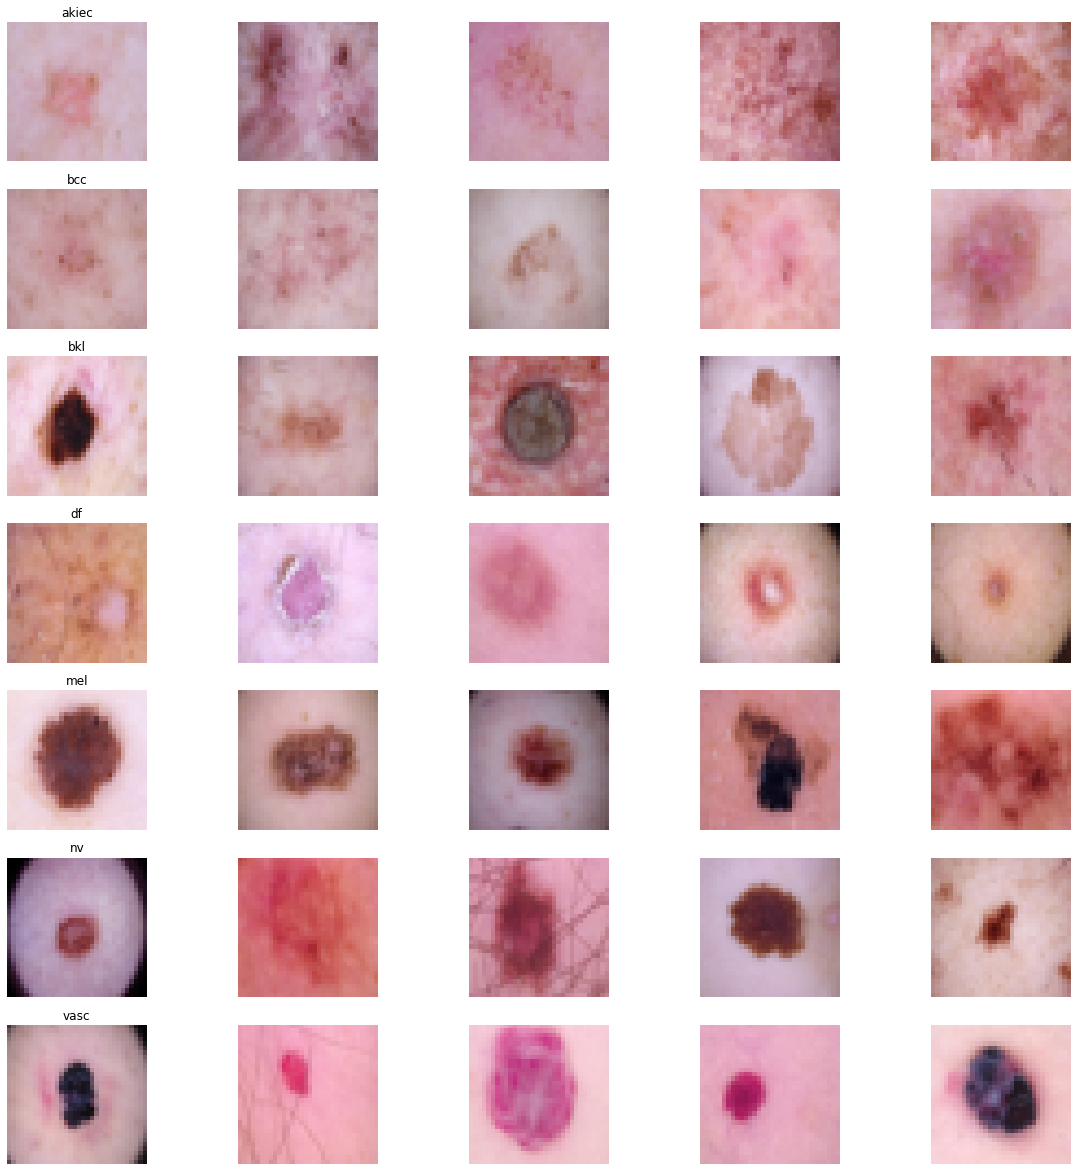

In [8]:
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [9]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization        dataset  \
1617             face   vidir_modern   
8128  lower extremity    vienna_dias   
2168             back      rosendahl   
1090            trunk  vidir_molemax   
7754          abdomen   vidir_mod

## Analysing the distribution of data

C:\Users\harsh\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


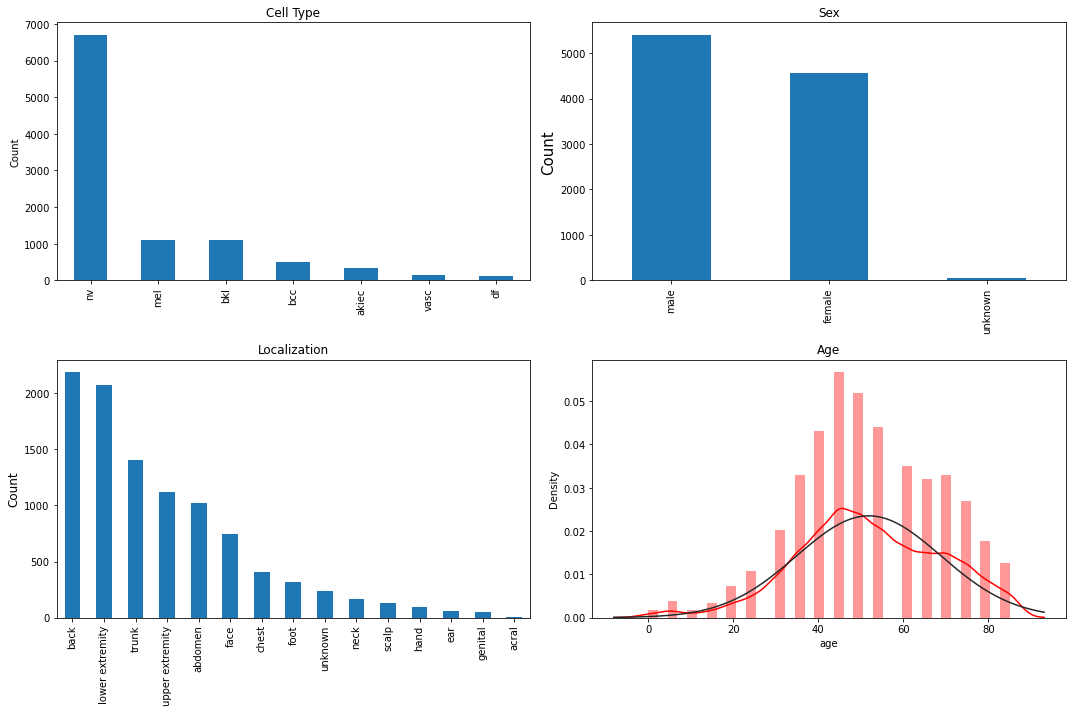

In [10]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [11]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


## Balance data

In [12]:

#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

## Splitting of dataset into training set and test set

In [14]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


## Define the model

In [17]:

#import more libraries

from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 7

#Sequential model

SIZE = 32

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)        

## Train the model

In [19]:

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
165/165 - 13s - loss: 1.4189 - acc: 0.4316 - val_loss: 1.4016 - val_acc: 0.4320 - 13s/epoch - 80ms/step
Epoch 2/50
165/165 - 13s - loss: 1.3853 - acc: 0.4514 - val_loss: 1.4720 - val_acc: 0.3943 - 13s/epoch - 81ms/step
Epoch 3/50
165/165 - 13s - loss: 1.3425 - acc: 0.4800 - val_loss: 1.3451 - val_acc: 0.4571 - 13s/epoch - 81ms/step
Epoch 4/50
165/165 - 13s - loss: 1.3271 - acc: 0.4773 - val_loss: 1.4232 - val_acc: 0.4160 - 13s/epoch - 80ms/step
Epoch 5/50
165/165 - 14s - loss: 1.2787 - acc: 0.5002 - val_loss: 1.2920 - val_acc: 0.4571 - 14s/epoch - 85ms/step
Epoch 6/50
165/165 - 14s - loss: 1.2444 - acc: 0.5093 - val_loss: 1.2477 - val_acc: 0.5109 - 14s/epoch - 83ms/step
Epoch 7/50
165/165 - 14s - loss: 1.2343 - acc: 0.5158 - val_loss: 1.2172 - val_acc: 0.5029 - 14s/epoch - 84ms/step
Epoch 8/50
165/165 - 14s - loss: 1.1980 - acc: 0.5257 - val_loss: 1.3945 - val_acc: 0.4137 - 14s/epoch - 84ms/step
Epoch 9/50
165/165 - 14s - loss: 1.2590 - acc: 0.5044 - val_loss: 1.1947 - val_a

## Model analysis and visualization

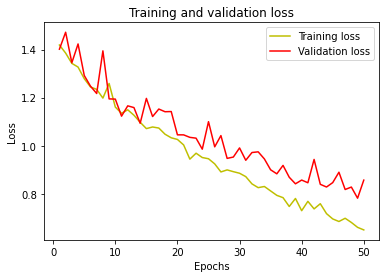

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

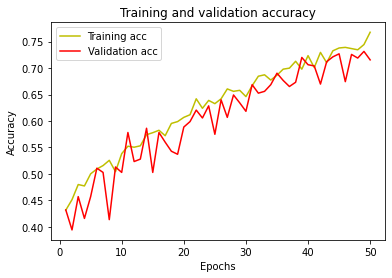

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

<AxesSubplot:>

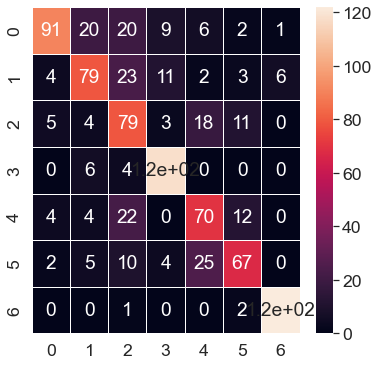

In [27]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

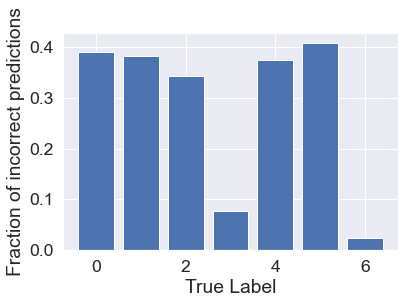

In [28]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')